In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [2]:
studentInfo = pd.read_csv('../data/studentInfo.csv')
studentAssessment = pd.read_csv('../data/studentAssessment.csv')
assessments = pd.read_csv('../data/assessments.csv')

In [3]:
studentInfo.shape

(32593, 12)

In [4]:
studentInfo.head(5)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [5]:
studentInfo.describe(include='all').head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
count,32593,32593,32593.000000,32593,32593,32593,31482,32593,32593.000000,32593.000000,32593,32593
unique,7,4,NaN,2,13,5,10,3,NaN,NaN,2,4
top,BBB,2014J,NaN,M,Scotland,A Level or Equivalent,20-30%,0-35,NaN,NaN,N,Pass
freq,7909,11260,NaN,17875,3446,14045,3654,22944,NaN,NaN,29429,12361
mean,NaN,NaN,706687.669131,NaN,NaN,NaN,NaN,NaN,0.163225,79.758691,NaN,NaN


In [6]:
studentInfo['final_result'].value_counts()
studentInfo['gender'].value_counts()

gender
M    17875
F    14718
Name: count, dtype: int64

final_result  Distinction  Fail  Pass  Withdrawn
gender                                          
F                    1394  3103  5735       4486
M                    1630  3949  6626       5670


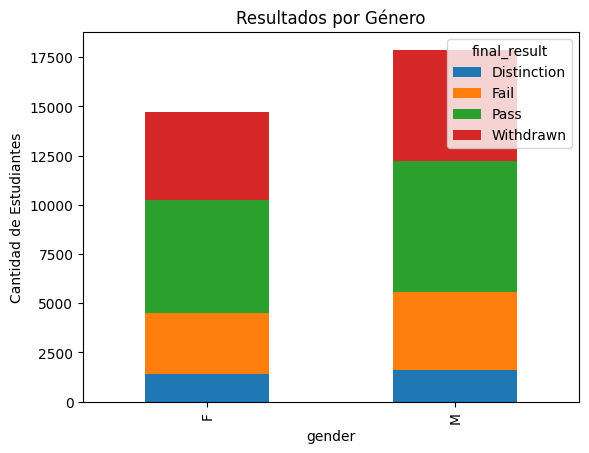

In [7]:
# Ejemplo: Distribución de resultados por género
pivot_result = studentInfo.pivot_table(index='gender', columns='final_result', aggfunc='size', fill_value=0)
print(pivot_result)
pivot_result.plot(kind='bar', stacked=True)
plt.title("Resultados por Género")
plt.ylabel("Cantidad de Estudiantes")
plt.show()


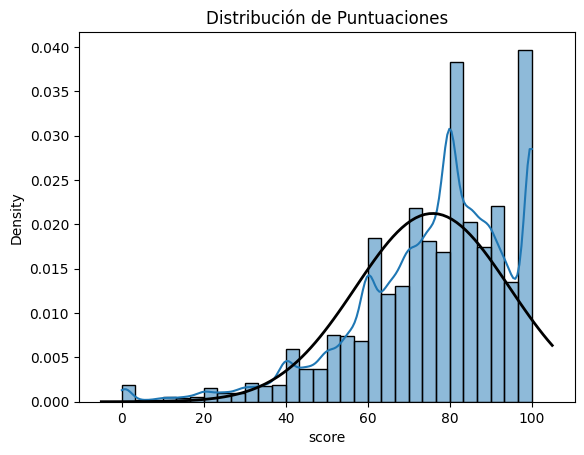

In [8]:
score_data = studentAssessment['score'].dropna()
sns.histplot(score_data, kde=True, stat="density", bins=30)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, score_data.mean(), score_data.std())
plt.plot(x, p, 'k', linewidth=2)
plt.title("Distribución de Puntuaciones")
plt.show()


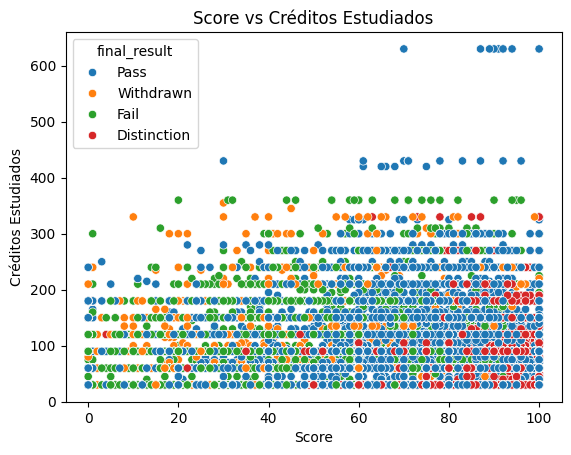

In [9]:
# Paso 1: Merge entre studentAssessment y assessments
assessment_join = pd.merge(studentAssessment, assessments, on='id_assessment')

# Paso 2: Merge con studentInfo usando las 3 claves necesarias
merged = pd.merge(assessment_join, studentInfo, on=['id_student', 'code_module', 'code_presentation'])

sns.scatterplot(data=merged, x='score', y='studied_credits', hue='final_result')
plt.title("Score vs Créditos Estudiados")
plt.xlabel("Score")
plt.ylabel("Créditos Estudiados")
plt.show()


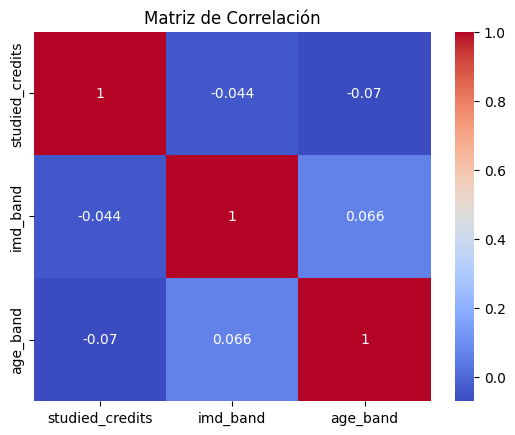

In [10]:
numeric_data = studentInfo[['studied_credits', 'imd_band', 'age_band']]
# Convertimos age_band e imd_band a numérico si es necesario
studentInfo['imd_band'] = studentInfo['imd_band'].map({'0-10%':1, '10-20%':2, '20-30%':3, '30-40%':4, '40-50%':5, 
                                                       '50-60%':6, '60-70%':7, '70-80%':8, '80-90%':9, '90-100%':10})
studentInfo['age_band'] = studentInfo['age_band'].map({'0-35':1, '35-55':2, '55<=':3})
correlation = studentInfo[['studied_credits', 'imd_band', 'age_band']].corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()


P-valor: 0.0008827203938431326


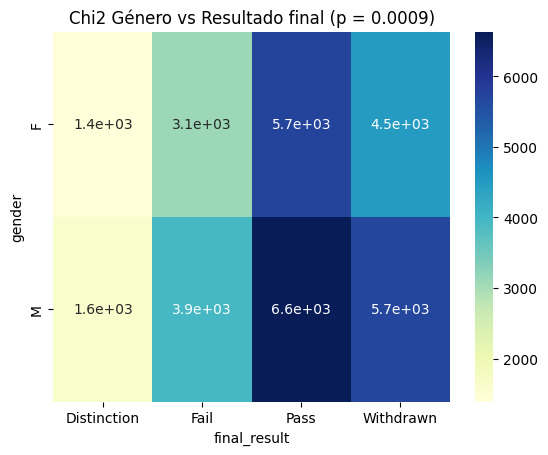

In [11]:
# Ejemplo: ¿Existe relación entre género y resultado final?
contingencia = pd.crosstab(studentInfo['gender'], studentInfo['final_result'])
chi2, p, dof, expected = stats.chi2_contingency(contingencia)
print(f"P-valor: {p}")
sns.heatmap(contingencia, annot=True, cmap="YlGnBu")
plt.title(f"Chi2 Género vs Resultado final (p = {p:.4f})")
plt.show()


In [12]:
# Selección de variables relevantes
data_model = studentInfo[['final_result', 'gender', 'age_band', 'disability', 'studied_credits', 'imd_band']].dropna()

# Convertir categóricas a numéricas
for col in ['final_result', 'gender', 'age_band', 'disability', 'imd_band']:
    le = LabelEncoder()
    data_model[col] = le.fit_transform(data_model[col])

X = data_model.drop('final_result', axis=1)
y = data_model['final_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       536
           1       0.33      0.00      0.00      1246
           2       0.40      0.79      0.53      2081
           3       0.43      0.37      0.40      1731

    accuracy                           0.41      5594
   macro avg       0.29      0.29      0.23      5594
weighted avg       0.36      0.41      0.32      5594



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Classification:")
print(classification_report(y_test, y_pred_svm))

SVM Classification:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       536
           1       0.00      0.00      0.00      1246
           2       0.40      0.70      0.51      2081
           3       0.41      0.47      0.44      1731

    accuracy                           0.41      5594
   macro avg       0.20      0.29      0.24      5594
weighted avg       0.28      0.41      0.33      5594



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
